In [1]:
%reset -f
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import imutils

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


In [11]:
def isSquare(approx, originalImg):
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        if 30 < w and w < 70 and 30 < h and h < 70 and ar >= 0.95:    
            print("It's square")
            return True, (x,y,w,h)#originalImg[x + w//2, y + h//2] 
    return False, None
        

def isolateBox(inputImage):
    gray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key = cv2.contourArea)
        
    imCopy = cv2.drawContours(thresh.copy() * 0, largest_areas, -1, (255,255,255), 3)
    # Copy the thresholded image.
    im_floodfill = imCopy.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = thresh.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (10,10), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = imCopy | im_floodfill_inv
    result = cv2.bitwise_and(inputImage, inputImage, mask = im_out)
    
#     squares = []
#     rotation = []
#     for cont in contours:
#         peri = cv2.arcLength(cont, True)
#         approx = cv2.approxPolyDP(cont, 0.05 * peri, True)
#         (found, pixel) = isSquare(approx, result)
#         if found:
#             #result = cv2.fillPoly(result, [cont], color = (0,255,0)) 
#             rect = cv2.minAreaRect(cont)
#             box = cv2.boxPoints(rect)
#             box = np.int0(box)
#             squares.append(pixel)
#             print(rect[2])
#             rotation.append(rect[2])
#             result = cv2.drawContours(result,[cont],0,(0,0,255),2)
    
    #result = cv2.drawContours(result,[squares[1]],0,(0,0,255),2)
    return result, 0#sorted(rotation)[-1]

In [3]:
images = glob.glob('Images/*.tif')
images

['Images/ID0036.tif',
 'Images/ID0037.tif',
 'Images/ID0038.tif',
 'Images/ID0039.tif',
 'Images/ID0040.tif',
 'Images/ID0041.tif',
 'Images/ID0042.tif',
 'Images/ID0043.tif',
 'Images/ID0044.tif',
 'Images/ID0045.tif',
 'Images/ID0046.tif',
 'Images/ID0047.tif',
 'Images/ID0048.tif',
 'Images/ID0049.tif',
 'Images/ID0050.tif',
 'Images/ID0051.tif',
 'Images/ID0052.tif',
 'Images/ID0053.tif',
 'Images/ID0054.tif',
 'Images/ID0055.tif',
 'Images/ID0056.tif',
 'Images/ID0057.tif',
 'Images/ID0058.tif',
 'Images/ID0059.tif',
 'Images/ID0060.tif',
 'Images/ID0061.tif',
 'Images/ID0062.tif',
 'Images/ID0063.tif',
 'Images/ID0064.tif',
 'Images/ID0065.tif',
 'Images/ID0066.tif',
 'Images/ID0067.tif',
 'Images/ID0068.tif',
 'Images/ID0069.tif',
 'Images/ID0070.tif',
 'Images/ID0071.tif',
 'Images/ID0072.tif',
 'Images/ID0073.tif',
 'Images/ID0074.tif',
 'Images/ID0075.tif',
 'Images/ID0076.tif',
 'Images/ID0077.tif',
 'Images/ID0078.tif',
 'Images/ID0079.tif',
 'Images/ID0080.tif',
 'Images/I

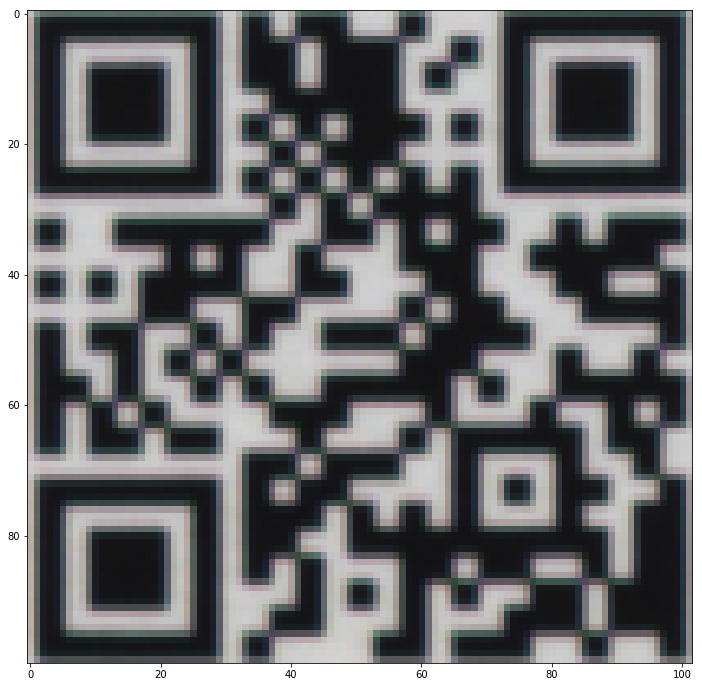

In [4]:
qr_code = cv2.imread("qr_code.tiff")
plt.imshow(cv2.cvtColor(qr_code, cv2.COLOR_BGR2RGB))

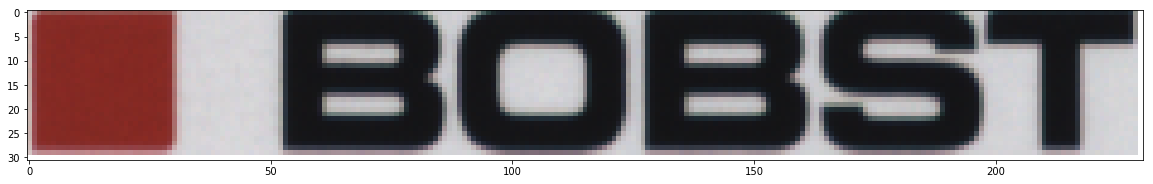

In [5]:
bobst = cv2.imread("bobst.tiff")
plt.imshow(cv2.cvtColor(bobst, cv2.COLOR_BGR2RGB))

In [6]:
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
def calc_A(v1,v2,v3,v1_img,v2_img,v3_img):
    primary = np.array([v1,v2,v3])
    secondary = np.array([v1_img,v2_img,v3_img])

    n = primary.shape[0]
    # Pad the data with ones, so that our transformation can do translations too
    X = pad(primary)
    Y = pad(secondary)
    # Solve the least squares problem X * A = Y
    # to find our transformation matrix A
    A, res, rank, s = np.linalg.lstsq(X, Y)
    return A

#A=calc_A(v1,v2,v3,v1_img,v2_img,v3_img)
#transform = lambda x: unpad(np.dot(pad(x), A))

v1_img = (164, 556)
v2_img = (215, 606) 
v3_img = (685, 572)

def get_one_match(image, imageGray, templateGray):
    # Find template
    result = cv2.matchTemplate(imageGray,templateGray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    h,w = templateGray.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image,top_left, bottom_right,(0,0,255), 2)
    return (top_left, bottom_right)

def template_matching(img, t1, t2):
    # resize images
    image = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
    template1 = cv2.resize(t1, (0,0), fx=0.5, fy=0.5) 
    template2 = cv2.resize(t2, (0,0), fx=0.5, fy=0.5) 


    # Convert to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template1Gray = cv2.cvtColor(template1, cv2.COLOR_BGR2GRAY)
    template2Gray = cv2.cvtColor(template2, cv2.COLOR_BGR2GRAY)
    
    one = get_one_match(image, imageGray, template1Gray)
    two = get_one_match(image, imageGray, template2Gray)
    print(one, two)
    
    return image, one, two
    


In [9]:
def get_affine(one, two):
    v1 = one[0]
    v2 = one[1]
    v3 = two[0]
#     return calc_A(v1,v2,v3,v1_img,v2_img,v3_img)
    pts1 = np.float32([v1,v2,v3])
    pts2 = np.float32([v1_img, v2_img,v3_img])
    M = cv2.getAffineTransform(pts1,pts2)
    return M
    

In [22]:

results_img = []
for input in images[:10]:
#     img = cv2.imread("rotated.tif")
    img = cv2.imread(input)
    img, rotation = isolateBox(img)
#     print(rotation)
    result, one, two = template_matching(img, qr_code, bobst) #imutils.rotate(result, rotation)
    A = get_affine(one,two)
    rows,cols,ch = result.shape
    result = cv2.warpAffine(result, A, (cols, rows))
    y_cornerSW = 100
    x_cornerSW = 100
    width = 1800
    height = 1500
    result = cv2.cvtColor(result[y_cornerSW:y_cornerSW+height, x_cornerSW:x_cornerSW+width] ,cv2.COLOR_BGR2GRAY)
    results_img.append(result)

correct = results_img[0]
k = 0
for one in results_img[1:]:
#     diffImage = cv2.absdiff(correct, one)
#     foregroundMask = np.zeros((diffImage.shape[0],diffImage.shape[1],3), np.uint8)
#     for j in range(diffImage.shape[0]):
#         for i in range(diffImage.shape[1]):
#             if np.linalg.norm(diffImage[j, i]) > 100:
#                 foregroundMask[j, i] = 255
    cv2.imwrite("output/"+ str(k) + ".tif", one)
    k += 1
    
#     out = os.path.basename(input)
#     cv2.imwrite("output/"+out, result)
#     plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

((164, 556), (215, 606)) ((685, 571), (801, 587))
((164, 558), (215, 608)) ((684, 573), (800, 589))
((164, 557), (215, 607)) ((684, 573), (800, 589))
((164, 558), (215, 608)) ((685, 573), (801, 589))
((164, 557), (215, 607)) ((685, 573), (801, 589))
((164, 558), (215, 608)) ((684, 574), (800, 590))
((164, 560), (215, 610)) ((685, 576), (801, 592))
((164, 559), (215, 609)) ((684, 575), (800, 591))
((163, 555), (214, 605)) ((684, 571), (800, 587))
((164, 560), (215, 610)) ((684, 577), (800, 593))


In [ ]:
imageA = cv2.imread(images[23])
rotated = imutils.rotate(imageA, 2)
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))